### B1 viz

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.sparse
import anndata
import seaborn as sns
import scvelo as scv

import milopy.core as milo
import milopy.plot as milopl

In [3]:
from scipy.sparse import csr_matrix

In [4]:
figdir = "/home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/B1_viz/"
if os.path.exists(figdir):
    sc.settings.figdir = figdir
else:
    os.mkdir(figdir)
    sc.settings.figdir = figdir

In [5]:
## r2py setup
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

anndata2ri.activate()

In [6]:
%load_ext rpy2.ipython

In [7]:
%%R
library(tidyverse)
library(reshape2)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

In [8]:
## Read annotation groupings
import json
with open('../../metadata/anno_groups.json', 'r') as json_file:
    anno_groups_dict = json.load(json_file)
    
anno_groups_dict_rev = {x:g for g,a in anno_groups_dict.items() for x in a}

### Load dataset

In [9]:
data_dir = '/nfs/team205/ed6/data/Fetal_immune/cellxgene_h5ad_files/scRNA_data/'
split='LYMPHOID'

In [10]:
adata = sc.read_h5ad(data_dir + 'PAN.A01.v01.raw_count.20210429.{s}.embedding.h5ad'.format(s=split))

### Subset to mature B cells

In [29]:
adata_b = adata[adata.obs['celltype_annotation'].isin(["MATURE_B", "B1", "PLASMA_B", "CYCLING_B","IMMATURE_B"])].copy()

In [30]:
sc.pp.normalize_per_cell(adata_b, counts_per_cell_after=10e4)
sc.pp.log1p(adata_b)

### Aggregate by sample for plotting

In [409]:
b_genes = {'other':['MS4A1'], 
           "IMMATURE_B":[ "CD19", "VPREB3"],
           'PLASMA_B':["JCHAIN",'CD38', "SDC1"],
           'B1':['CD27','CD5',"SPN"],
           'CYCLING':["MKI67"],
           'ccr10':["CCR10"]
          }

In [421]:
genes = sum(list(b_genes.values()), [])

gex = pd.DataFrame(adata_b[:,genes].X.toarray())
gex.index = adata_b.obs_names
gex.columns = genes

gex['annotation'] = adata_b.obs['celltype_annotation'].copy()
gex['sample'] = adata_b.obs['file'].copy()

In [418]:
gex = gex.groupby(['annotation', "sample"]).mean().fillna(0)

In [411]:
gex = gex.reset_index()

In [412]:
gene_groups_df = pd.DataFrame([(k,x) for k,v in b_genes.items() for x in v],
            columns=['group','gene'])

In [413]:
%%R -i gex -i gene_groups_df 
head(gex)

  annotation         sample    MS4A1     CD19   VPREB3    JCHAIN      CD38
0         B1 FCAImmP7179363 4.622228 1.268932 1.779910 2.2294185 1.4457712
1         B1 FCAImmP7179365 4.811032 1.680175 3.014248 2.1780062 0.8110200
2         B1 FCAImmP7179366 0.000000 0.000000 0.000000 0.0000000 0.0000000
3         B1 FCAImmP7179367 4.993029 1.528029 1.931381 0.9576527 1.5795075
4         B1 FCAImmP7179368 0.000000 0.000000 0.000000 0.0000000 0.0000000
5         B1 FCAImmP7179369 5.140726 2.448736 2.097649 1.5131042 0.3820813
        SDC1      CD27       CD5       SPN     MKI67      CCR10
0 0.17619178 1.1109165 0.5041918 0.7534212 0.6644280 0.36852092
1 0.01069695 0.7218007 0.5875961 0.5265101 0.1819086 0.09964437
2 0.00000000 0.0000000 0.0000000 0.0000000 0.0000000 0.00000000
3 0.16458726 0.1632785 0.5234485 0.7576301 1.7033535 0.36623576
4 0.00000000 0.0000000 0.0000000 0.0000000 0.0000000 0.00000000
5 0.00000000 0.1725813 0.3460629 0.7655897 0.4215367 0.06355132


Joining, by = "gene"


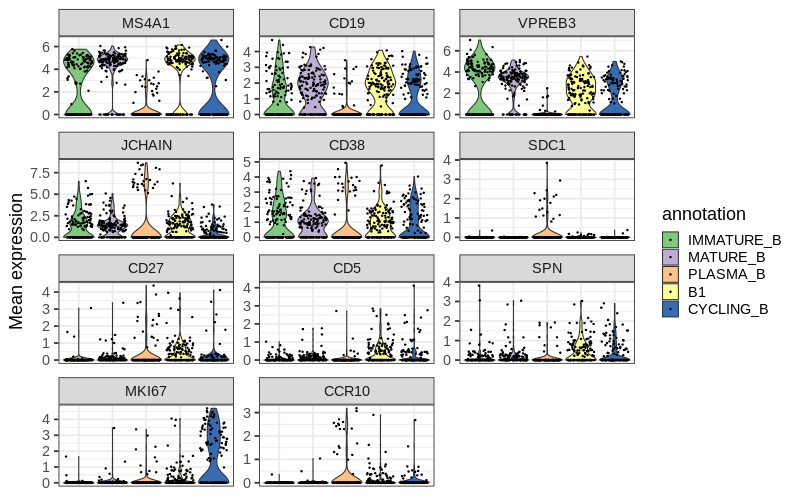

In [408]:
%%R -h 500 -w 800 -i genes
pl_gex_df <- gex %>%
    pivot_longer(cols = -c(annotation, sample), names_to='gene', values_to='expression') %>%
    left_join(gene_groups_df) %>%
    mutate(gene=factor(gene, levels=genes)) %>%
    mutate(annotation=factor(annotation, levels=c("IMMATURE_B", "MATURE_B", "PLASMA_B", "B1", "CYCLING_B"))) 
    
pl_gex_df %>%
    ggplot(aes(annotation,expression, fill=annotation)) +
    geom_violin(scale='width') +
    geom_jitter(size=0.5) +
    facet_wrap(gene~., ncol=3, scales='free') +
    scale_size(range=c(0,10)) +
    theme_bw(base_size=18) +
    remove_x_axis() +
    ylab("Mean expression") +
    scale_fill_brewer(palette="Accent") +
    ggsave("/home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/B1_viz/expression_violins.pdf", width=10, height=7)

In [433]:
gex[gex['annotation'] == 'B1']

,MS4A1,CD19,VPREB3,JCHAIN,CD38,SDC1,CD27,CD5,SPN,MKI67,CCR10,annotation,sample
index,,,,,,,,,,,,,
FCAImmP7579224-CACCTTGAGTAGCCGA,4.795907,3.099144,3.591770,3.591770,2.086871,0.0,0.00000,2.715973,2.086871,0.000000,0.000000,B1,FCAImmP7579224
FCAImmP7579224-ACCGTAATCCGTCAAA,4.101700,2.250433,3.771823,3.554416,0.000000,0.0,0.00000,2.889466,0.000000,0.000000,0.000000,B1,FCAImmP7579224
FCAImmP7579224-GGGAGATTCTCAAACG,4.761563,0.000000,3.185762,4.761563,0.000000,0.0,0.00000,2.533130,0.000000,0.000000,0.000000,B1,FCAImmP7579224
FCAImmP7803039-TCGTACCAGCCACGTC,6.040640,3.711623,4.613142,0.000000,3.042620,0.0,3.04262,0.000000,0.000000,0.000000,0.000000,B1,FCAImmP7803039
FCAImmP7198630-CCCAGTTAGGATGCGT,3.798531,1.036080,1.036080,2.311619,2.477285,0.0,0.00000,1.036080,1.036080,2.619368,1.864769,B1,FCAImmP7198630
...,...,...,...,...,...,...,...,...,...,...,...,...,...
FCAImmP7803020-CCACCTATCTTCTGGC,5.984575,0.000000,4.291091,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,B1,FCAImmP7803020
FCAImmP7803020-TCAACGACATAGAAAC,4.703471,0.000000,4.302527,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,B1,FCAImmP7803020
FCAImmP7803020-AAGTCTGTCCTTAATC,5.017528,3.650902,4.330980,0.000000,0.000000,0.0,0.00000,0.000000,3.650902,0.000000,0.000000,B1,FCAImmP7803020


In [434]:
sum(gex[gex['annotation'] == 'B1']['CD27']>0)/gex[gex['annotation'] == 'B1'].shape[0]

0.23319179051663128

In [1]:
import scarches

ModuleNotFoundError: No module named 'scarches'